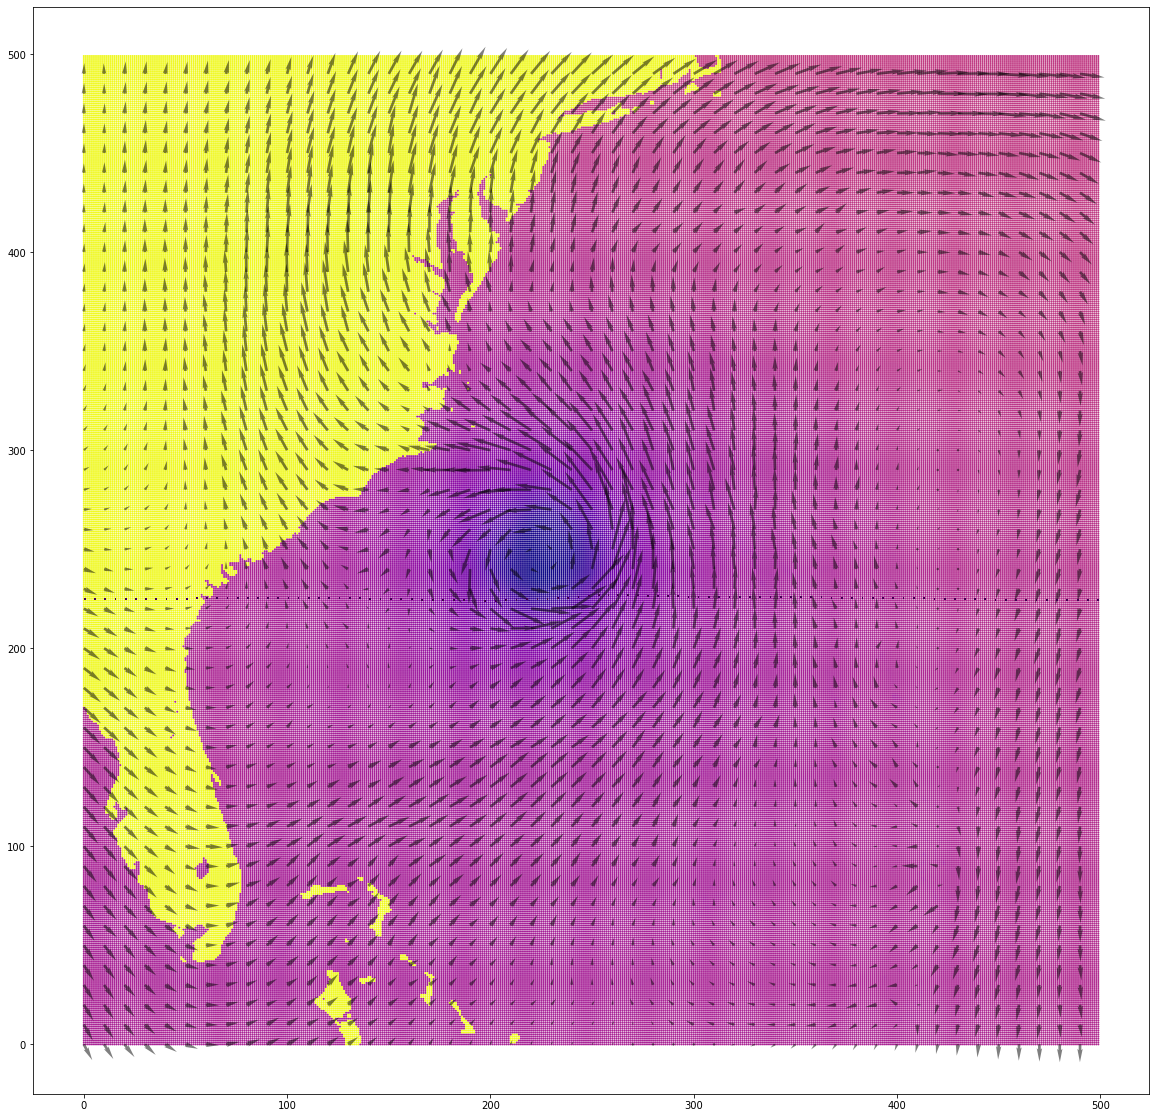

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import interpolate
# import numpy as np
# from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

# from numba import jit, prange
uData = []
vData = []

##### data loading and setup/plot image
##### argument "showBgMap": show or not to show the background map
##### DO NOT modify this function
def Initialize( showBgMap = False ):
    global uData
    global vData
    
    loadFlowData = np.load("flowData.npy",allow_pickle=True)

    ### flow data
    uData = loadFlowData.item().get('uData')
    vData = loadFlowData.item().get('vData')

    plt.rcParams['figure.figsize'] = [20, 20]
    
    ### plot backgroup images
    presMapX = loadFlowData.item().get('presMapX')
    presMapY = loadFlowData.item().get('presMapY')
    presMapV = loadFlowData.item().get('presMapV')
    if showBgMap == True:
        plt.scatter(presMapX, presMapY, s=1, c=presMapV, cmap='plasma')
    
    ### plot arrows
    x_pos = loadFlowData.item().get('x_pos')
    y_pos = loadFlowData.item().get('y_pos')
    x_direct = loadFlowData.item().get('x_direct')
    y_direct = loadFlowData.item().get('y_direct')       
    plt.quiver(x_pos, y_pos, x_direct, y_direct, scale = 50,  headwidth = 2, headlength = 5, alpha = 0.5)


##### x, y: location. Return: 2D vector at [x,y] (x and y are integer only)
##### return: a 2D vector [u, v], u is horizontal direction (right is postivie), v is the vertical direction (up is positive)
##### DO NOT modify this function
def getDataVector(x, y):
    return uData[(499-y)+500*x], vData[(499-y)+500*x]


##### this function generates "numSeeds" points(seeds) from [startX, startY] to [endX, endY]
##### Return: seeds -> a list of [x, y] 
def generateSeeds(startX, startY, endX, endY, numSeeds):
    seeds = []
    x = np.linspace(startX, endX, numSeeds )
    y = np.linspace(startY, endY, numSeeds )
    seeds = np.zeros([numSeeds,2])
    seeds[:, 0] = x
    seeds[:, 1] = y
    return seeds

##### this function plot a particle tracing result on the screen
##### argument "path": particle tracing result. It is represetned by a list of [x, y]. (x, y) can be floating point
##### You may not want to modify this function
def drawOneParticleTracingResult( path ):
    ps = np.array(path)
    c = np.linspace(1, 0, num=ps.shape[0])
    plt.scatter(ps[:,0], ps[:,1], c=c, s=3, marker='_')

##### (TODO) WORK on this function
##### compute ONE particle tracing result
##### you should use "getDataVector())" to get the vector you want on the grid point
##### if you need the vector between grid points, you have to implment the vector interpolation by your self
##### I do not mind the computation is efficnet or not
##### "seed": one seed (x,y)
##### "t": delta t (i suggest 0.025)
##### "steps": how many stesp for this particle tracing process
def find_cell_seed(x,y):
    if isinstance(x, float)and isinstance(y, float):
       p1=[int(x),int(y)]
       p2=[int(x)+1,int(y)]
       p3=[int(x)+1,int(y)+1]
       p4=[int(x),int(y)+1]
    #    return p1,p2,p3,p4
        
    elif isinstance(x, float)and y.is_integer():
        p1=[int(x),int(y)]
        p2=[int(x)+1,int(y)]
        p3=[int(x)+1,int(y)]
        p4=[int(x),int(y)]
        # return p1,p2,p3,p4
    elif isinstance(y, float)and x.is_integer():
        p1=[int(x),int(y)]
        p2=[int(x),int(y)]
        p3=[int(x),int(y)+1]
        p4=[int(x),int(y)+1]
    return p1,p2,p3,p4
        


def RK4_1D(p,v,t):
    a = 2*t*v #
    b = 2*t*(v+a/2)
    c =2*t*(v+b/2)
    d =2*t*(v+c/2)
    p_next = p+(a+2*b+2*c+d)/6
    return p_next

   
def getinterpolation(x0,x1,y0,y1,datavalue):
    return y0+(datavalue-x0)*((y1-y0)/(x1-x0))
    
def particleTrace(seed, t, steps):
    
    x=seed[0]
    y=seed[1]
  
    if  ( x.is_integer()and y.is_integer()):
        u=getDataVector(int(x),int(y))[0]
        v=getDataVector(int(x),int(y))[1]
    else:
        # print("float")
        p1,p2,p3,p4 = find_cell_seed(x,y)
   
        # print("fourp",p1,p2,p3,p4 )
        pv1 =getDataVector(int(p1[0]),int(p1[1]))
        pv2 =getDataVector(int(p2[0]),int(p2[1]))
        pv3 =getDataVector(int(p3[0]),int(p3[1]))
        pv4 =getDataVector(int(p4[0]),int(p4[1]))
        # print("fourv",pv1,pv2,pv3,pv4)
        # R1=getinterpolation(x0 = p1[0],y0=pv1[0],x1= p1[1],y1= pv1[1],datavalue=x)
        her_x01=getinterpolation(x0 = p1[0],y0=pv1[0],x1= p2[0],y1= pv2[0],datavalue=x)
        her_x02=getinterpolation(x0 = p4[0],y0=pv4[0],x1= p3[0],y1= pv3[0],datavalue=x)
        her_y01=getinterpolation(x0 = p1[1],y0=pv1[1],x1= p3[1],y1= pv3[1],datavalue=y)
        her_y02=getinterpolation(x0 = p2[1],y0=pv2[1],x1= p4[1],y1= pv4[1],datavalue=y)
    
        u = (her_x01+her_x02)/2
        v = (her_y01+her_y02)/2
  
      
    path = []
    for i in range(steps):
# #         

        point_RK4 = [RK4_1D(x, u, t), RK4_1D(
                y,v, t)]
        path.append( point_RK4 )
    return path
  

##### main (if you want, you can change the arguments in the generateSeeds() and the last argument in particleTrace() )
Initialize(True) ## set False to disable backgroup image display (faster a little bit)

seeds = generateSeeds(0, 225, 499, 225, 100)
 ##this line generates seeds (seeds to generate the graph on the homework description slides)




for seed in seeds: ###iterate through all seeds
    path = particleTrace(seed, 0.025, 10000) # compute one particle tracing of the "seed", result is a list of [x,y ]
    drawOneParticleTracingResult(path) # draw one particle path
    # print(path)
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices